In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

import joblib

In [2]:
file_path = r'Dataset\cleaned_heart_failure_dataset_v3.csv'  # Replace with your dataset path
df = pd.read_csv(file_path)

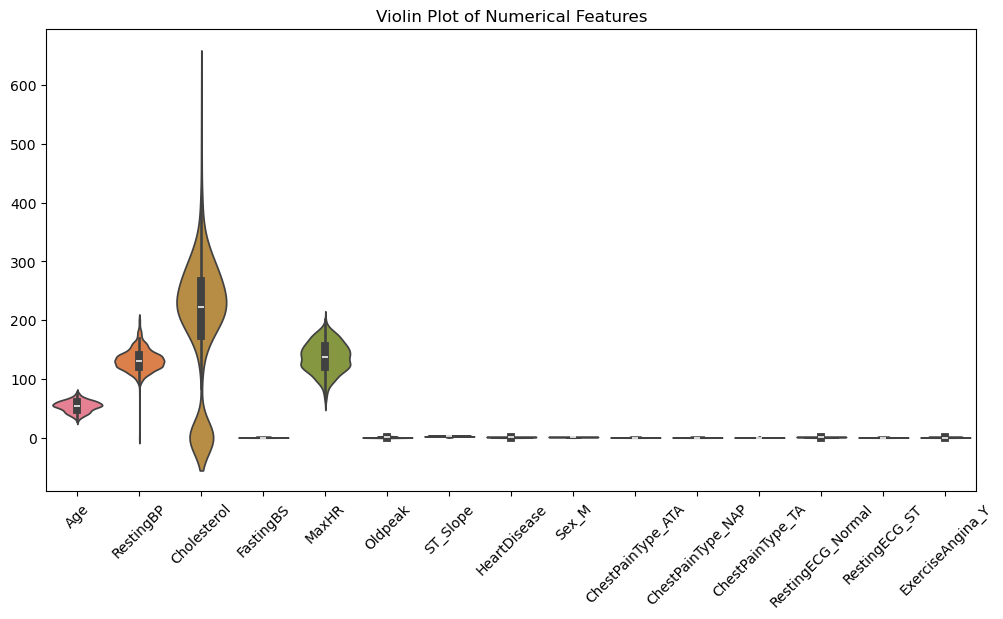

In [3]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df)
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Violin Plot of Numerical Features")
plt.show()


In [4]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,ST_Slope,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y
0,40,140,289,0,172,0.0,3,0,True,True,False,False,True,False,False
1,49,160,180,0,156,1.0,2,1,False,False,True,False,True,False,False
2,37,130,283,0,98,0.0,3,0,True,True,False,False,False,True,False
3,48,138,214,0,108,1.5,2,1,False,False,False,False,True,False,True
4,54,150,195,0,122,0.0,3,0,True,False,True,False,True,False,False


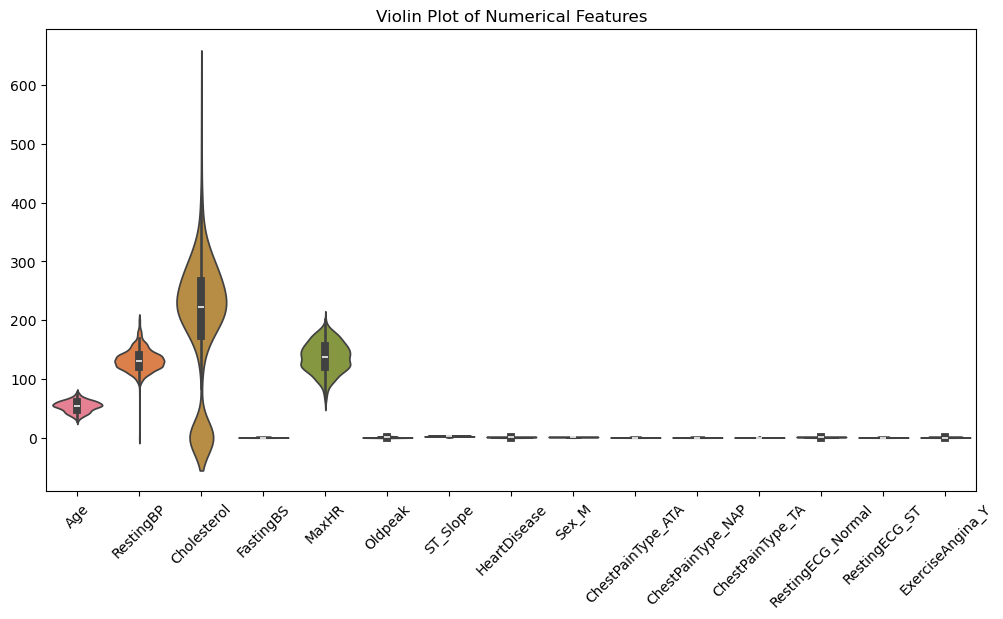

In [5]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df)
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.title("Violin Plot of Numerical Features")
plt.show()


In [6]:
for x in df.columns:
    print(x)
    print(df[x].mean())
    print('==================')

Age
53.510893246187365
RestingBP
132.39651416122004
Cholesterol
198.7995642701525
FastingBS
0.23311546840958605
MaxHR
136.80936819172112
Oldpeak
0.8873638344226579
ST_Slope
2.3616557734204795
HeartDisease
0.5533769063180828
Sex_M
0.789760348583878
ChestPainType_ATA
0.18845315904139434
ChestPainType_NAP
0.22113289760348584
ChestPainType_TA
0.05010893246187364
RestingECG_Normal
0.6013071895424836
RestingECG_ST
0.19389978213507625
ExerciseAngina_Y
0.40413943355119825


In [61]:
# Define the target variable and features
X = df.drop(columns=['HeartDisease'])  # Features
y = df['HeartDisease']  # Target variable

# pca = PCA(n_components=5)  # Adjust as needed
# X_pca = pca.fit_transform(X)  # Use your scaled data
# X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])


# Assume X and y are your features and labels
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp)

# Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_test_scaled = scaler.transform(X_test)


# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (642, 14), X_test shape: (138, 14)
y_train shape: (642,), y_test shape: (138,)


In [62]:
df["HeartDisease"].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [63]:
# Define the base model
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum samples needed to split
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the model with the best parameters
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)


# Make predictions
y_pred_rf = best_rf.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.91

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        61
           1       0.89      0.96      0.93        77

    accuracy                           0.91       138
   macro avg       0.92      0.91      0.91       138
weighted avg       0.92      0.91      0.91       138



In [64]:
y_val_pred_rf = best_rf.predict(X_val)
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)

print(f"Validation Accuracy: {val_accuracy_rf:.2f}")
print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred_rf))

Validation Accuracy: 0.87

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        62
           1       0.88      0.88      0.88        76

    accuracy                           0.87       138
   macro avg       0.87      0.87      0.87       138
weighted avg       0.87      0.87      0.87       138



In [65]:
# Collect predictions in a list
predictions = []
for index, row in X.iterrows():
    # best_rf.predict expects a 2D array: [row.values] creates an array with one row.
    pred = best_rf.predict([row.values])
    predictions.append(pred[0])  # pred is an array, so extract the element

# Create a DataFrame that compares true and predicted values
results_df = pd.DataFrame({
    'y_true': y,           # True target values
    'y_pred': predictions  # Model predictions
}, index=X.index)

c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have 

In [66]:
print(results_df.head())

   y_true  y_pred
0       0       0
1       1       0
2       0       0
3       1       1
4       0       0


In [67]:
print(results_df)

     y_true  y_pred
0         0       0
1         1       0
2         0       0
3         1       1
4         0       0
..      ...     ...
913       1       1
914       1       1
915       1       1
916       1       0
917       0       0

[918 rows x 2 columns]


In [68]:
for index, row in results_df.iterrows():
    print(f"Index: {index}, Prediction: {row['y_pred']}, Real: {row['y_true']}")

Index: 0, Prediction: 0, Real: 0
Index: 1, Prediction: 0, Real: 1
Index: 2, Prediction: 0, Real: 0
Index: 3, Prediction: 1, Real: 1
Index: 4, Prediction: 0, Real: 0
Index: 5, Prediction: 0, Real: 0
Index: 6, Prediction: 0, Real: 0
Index: 7, Prediction: 0, Real: 0
Index: 8, Prediction: 1, Real: 1
Index: 9, Prediction: 0, Real: 0
Index: 10, Prediction: 0, Real: 0
Index: 11, Prediction: 1, Real: 1
Index: 12, Prediction: 0, Real: 0
Index: 13, Prediction: 1, Real: 1
Index: 14, Prediction: 0, Real: 0
Index: 15, Prediction: 0, Real: 0
Index: 16, Prediction: 1, Real: 1
Index: 17, Prediction: 0, Real: 0
Index: 18, Prediction: 1, Real: 1
Index: 19, Prediction: 1, Real: 1
Index: 20, Prediction: 0, Real: 0
Index: 21, Prediction: 1, Real: 0
Index: 22, Prediction: 0, Real: 0
Index: 23, Prediction: 1, Real: 1
Index: 24, Prediction: 0, Real: 0
Index: 25, Prediction: 0, Real: 0
Index: 26, Prediction: 1, Real: 0
Index: 27, Prediction: 0, Real: 0
Index: 28, Prediction: 0, Real: 0
Index: 29, Prediction: 0

In [69]:
import joblib

# Save the trained RandomForestClassifier model
joblib.dump(best_rf, "models/rf_model.pkl")

print("Model saved successfully!")

Model saved successfully!


In [70]:
import joblib

# Load the trained model
best_rf = joblib.load("models/rf_model.pkl")


In [71]:
best_rf

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)

In [72]:
# Collect predictions in a list
predictions2 = []
for index, row in X.iterrows():
    # best_rf.predict expects a 2D array: [row.values] creates an array with one row.
    pred = best_rf.predict([row.values])
    predictions2.append(pred[0])  # pred is an array, so extract the element

# Create a DataFrame that compares true and predicted values
results_df2 = pd.DataFrame({
    'y_true': y,           # True target values
    'y_pred': predictions  # Model predictions
}, index=X.index)

c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\LENOVO\anaconda3\envs\comp_vision\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have 

In [77]:
for index, row in results_df2.iterrows():
    print(f"Index: {index}, Prediction: {row['y_pred']}, Real: {row['y_true']}")

Index: 0, Prediction: 0, Real: 0
Index: 1, Prediction: 0, Real: 1
Index: 2, Prediction: 0, Real: 0
Index: 3, Prediction: 1, Real: 1
Index: 4, Prediction: 0, Real: 0
Index: 5, Prediction: 0, Real: 0
Index: 6, Prediction: 0, Real: 0
Index: 7, Prediction: 0, Real: 0
Index: 8, Prediction: 1, Real: 1
Index: 9, Prediction: 0, Real: 0
Index: 10, Prediction: 0, Real: 0
Index: 11, Prediction: 1, Real: 1
Index: 12, Prediction: 0, Real: 0
Index: 13, Prediction: 1, Real: 1
Index: 14, Prediction: 0, Real: 0
Index: 15, Prediction: 0, Real: 0
Index: 16, Prediction: 1, Real: 1
Index: 17, Prediction: 0, Real: 0
Index: 18, Prediction: 1, Real: 1
Index: 19, Prediction: 1, Real: 1
Index: 20, Prediction: 0, Real: 0
Index: 21, Prediction: 1, Real: 0
Index: 22, Prediction: 0, Real: 0
Index: 23, Prediction: 1, Real: 1
Index: 24, Prediction: 0, Real: 0
Index: 25, Prediction: 0, Real: 0
Index: 26, Prediction: 1, Real: 0
Index: 27, Prediction: 0, Real: 0
Index: 28, Prediction: 0, Real: 0
Index: 29, Prediction: 0

In [78]:
results_df2 == results_df

,y_true,y_pred
0,True,True
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
913,True,True
914,True,True
915,True,True
916,True,True


In [ ]:
#### WITH PKL scaler

In [95]:
data = {
    'Age': [35],
    'Gender': [0],
    'cp': [3],
    'RestingBP': [120],
    'Cholesterol': [180],
    'FastingBS': [0],
    'restecg': [0],
    'MaxHR': [170],
    'exang': [0],
    'Oldpeak': [0.0],
    'slope': [1],
    'ca': [0],
    'thal': [3],
}

# Convert to DataFrame
df_non_heart_problem = pd.DataFrame(data)

# Display the DataFrame
print(df_non_heart_problem)

   Age  Gender  cp  RestingBP  Cholesterol  FastingBS  restecg  MaxHR  exang  \
0   35       0   3        120          180          0        0    170      0   

   Oldpeak  slope  ca  thal  
0      0.0      1   0     3  


In [96]:
# Load the saved scaler
scaler = joblib.load("models/scaler.pkl")

# Ensure the data structure is correct for scaling
columns_needed = scaler.get_feature_names_out()
print(columns_needed)

['Age' 'RestingBP' 'Cholesterol' 'FastingBS' 'MaxHR' 'Oldpeak']


In [97]:
df_to_scale = df_non_heart_problem[columns_needed]

# Apply scaling
scaled_data = scaler.transform(df_to_scale)

# Convert back to DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=df_to_scale.columns)

# Display the scaled values
print(df_scaled)

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak
0 -1.963504  -0.669935    -0.171961  -0.551341  1.304332 -0.832432


In [ ]:
# Add back the missing columns from the original DataFrame
for col in df_non_heart_problem.columns:
    if col not in df_scaled.columns:
        df_scaled[col] = df_non_heart_problem[col].values  # Restore excluded columns

# Display the final DataFrame
print(df_scaled)

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  Gender  \
0 -1.963504  -0.669935    -0.171961  -0.551341  1.304332 -0.832432       0   

   cp  restecg  exang  slope  ca  thal  
0   3        0      0      1   0     3  


In [99]:
data_row = {
    'Age': df_scaled['Age'][0],
    'RestingBP': df_scaled['RestingBP'][0],
    'Cholesterol': df_scaled['Cholesterol'][0],
    'FastingBS': df_scaled['FastingBS'][0],
    'MaxHR': df_scaled['MaxHR'][0],
    'Oldpeak': df_scaled['Oldpeak'][0],
    'ST_Slope': 2 if data['slope'][0] == 2 else (1 if data['slope'][0] == 1 else 0),
    'Sex_M': data['Gender'][0],  # Assuming 1 = Male, 0 = Female
    'ChestPainType_ATA': 1 if data['cp'][0] == 2 else 0,  # Adjust based on encoding
    'ChestPainType_NAP': 1 if data['cp'][0] == 1 else 0,
    'ChestPainType_TA': 1 if data['cp'][0] == 3 else 0,
    'RestingECG_Normal': 1 if data['restecg'][0] == 0 else 0,
    'RestingECG_ST': 1 if data['restecg'][0] == 1 else 0,
    'ExerciseAngina_Y': 1 if data['exang'][0] == 1 else 0
}

In [105]:
df_test_row = pd.DataFrame([data_row])

# Display the DataFrame
print(df_test_row)

        Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  ST_Slope  \
0 -1.963504  -0.669935    -0.171961  -0.551341  1.304332 -0.832432         1   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0      0                  0                  0                 1   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  
0                  1              0                 0  


In [106]:
# Make prediction using best_rf model
prediction = best_rf.predict(df_test_row)

# Display the predicted value
print(f"Predicted Heart Disease Risk: {prediction[0]}")

Predicted Heart Disease Risk: 1


In [ ]:
######## WITH NORMAL SCALAR

In [107]:
# Load the dataset
file_path = r'Dataset\heart.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values (if any)
data = data.dropna()  # Drop rows with missing values (or use imputation if necessary)

# Descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None

Missing Values:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
Exerci